# Exercise 3.2: Linear Regression with Gradient Descent

In exercise 3.1 you have tackled the Ordinary Least Squares Linear Regression by calculating the analytical solution to estimate the coefficients $\hat{\boldsymbol w}$. In this assignment you will solve the same optimization problem using a standard numerical optimization method called Gradient Descent.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import datasets, linear_model
%matplotlib inline
import numpy.linalg as LA

## 3.2.1 Getting started with the data set

__Tasks:__ 
1. Visualize the given data X and y which will be used to fit a linear regression model. How many feature dimensions are contained?
2. Split the given data X and y into train (first 100 data points) and test set (last 200 data points).

__Hint:__ 
In this assignment, the augmented notation for the data $\mathbf{X}$ is used such that the estimated coefficients $\hat{\boldsymbol w}$ fit the augmented model $f(\mathbf X) = \mathbf X \hat{\boldsymbol w}$

__Answer:__
The data has only one feature dimension, the second column consists only of ones (due to the augmented notation).

X.shape: (300, 2), y.shape: (300,)
X_train.shape: (100, 2), y_train.shape: (100,)
X_test.shape: (200, 2), y_test.shape: (200,)


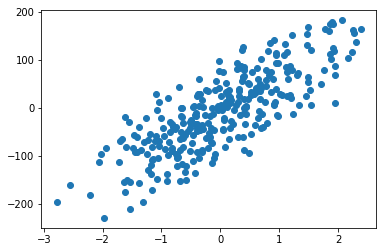

In [47]:
data_dir = 'data/GD_dataset1.data'
label_dir = 'data/GD_dataset1.labels'

X = np.loadtxt(data_dir)
y = np.loadtxt(label_dir)

# (1.) -> check the dimensionality of the given data
print(f'X.shape: {X.shape}, y.shape: {y.shape}')

# (1.) -> plot the given data (D=1)
fig, ax = plt.subplots(1, 1)
plt.scatter(X[:, 0], y)


# (2.) -> split the data in train/test set
X_train = X[:100,]
y_train = y[:100]
print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')

X_test = X[-200:,]
y_test = y[-200:]
print(f'X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}')

## 3.2.2 Explore the behaviour of the cost function

In order to compute the coefficients $\hat{\boldsymbol w}$ for the OLS Linear Regression, a cost function $J(\mathbf{w})$ has been introduced in the lecture.

__Tasks:__ 
1. Look up the definition of the cost function for ordinary least-squares (OLS) linear regression and implement it. The "cost_function()" should return a single scalar which is the evaluation of the cost function $J(\mathbf{w})$.
2. Evaluate your implemented cost function $J({w}_{1})$ by varying the parameter $w_{1}\in[-500, 600]$ (you can set the bias term $w_{0}=0$) using the training data $\mathbf{X}_{train}$ and $\mathbf{y}_{train}$. Plot the resulting cost function $J({w}_{1})$.


In [48]:
# (1.) -> Implementation of the cost function for linear regression

def cost_function(X, y, w):
    """cost_function(X, y, w) compute the MSE cost using w as the
    coefficients for linear regression to fit the data points in X and y
    
    Input:
    X: array with data matrix X
    y: observed output vector
    w: regression weights (compact form)

    Return: 
    J: scalar cost

    """
    ## number of training examples
    N_sam = X.shape[0]
     
    ## Calculate the MSE cost with the given parameters
    prediction = np.matmul(X, w)
    error = prediction - y.reshape(N_sam, 1)
    J = np.mean(np.power(error, 2), axis=0)
    
    return J

Text(0.5, 1.0, 'ridge loss')

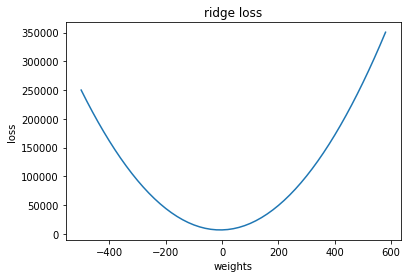

In [71]:
# (2.) -> Evaluation and plot the cost function for the given training data
w_range = np.arange(-500, 600, 20)
J = []
for w in w_range:
    weight = np.array([1, w]).reshape(2, 1)
    loss = cost_function(X, y, weight)
    J.append(loss)
w_range.shape

fig, ax = plt.subplots(1, 1)
ax.plot(w_range, J)
ax.set_xlabel('weights')
ax.set_ylabel('loss')
ax.set_title('ridge loss')

## 3.2.3 Optimize OLS Linear Regression with Gradient Descent

In 3.3.2. you have already explored the full landscape of the cost function. If we now assume that a single evaluation of J is (e.g. computationally) expensive, then you want to use a strategy with as few evaluations as possible to find $\boldsymbol w^{*}$ with the minimum cost $J({\boldsymbol w^{*}})$. To do so, we will now use an iterative approach to find $J(\boldsymbol w^{*})$ of the linear regression coefficients $\boldsymbol w$. The convergence of the utilized gradient descent algorithm shall be investigated with respect to its parameters (learning rate $\eta$, number of iterations $N_{iter}$) and its estimated coefficients $\hat{\boldsymbol w}$ shall be compared to those the analytical solution of the OLS linear regression.

__Tasks:__

1. Lookup the scikit-learn toolbox implementation of the analytical OLS linear regression model or use your code of Assignment 3.1. Train the model on the given training data $\mathbf{X}_{train}$ and $\mathbf{y}_{train}$ and print the estimated coefficients $\hat{\boldsymbol w}$ of the analytical solution.
2. Inspect the given function "gradient_descent()" (below). Use it to optimize the cost function by varying the number of iteration steps as $N_{iter}\in\{2,5,10,20,40\}$. Keep the learning rate fixed at $\eta=0.1$ and use the given starting value $\boldsymbol w_{start}=(-400,0)^{T}$.
3. Create a scatter plot of the test data $\mathbf{X}_{test}$ and $\mathbf{y}_{test}$ and add the corresponding linear regression fit for each parameter configuration $N_{iter}$ to the plot. In addition, add the linear regression fit that you gained from the analytical solution in (1.).
4. Plot the cost function of part 3.3.2 again and add the five evalutated cost function values gained by varying  $N_{iter}$.
5. Repeat the steps (2.)-(4.) by varying the learning rate $\eta \in \{10^{-4}, 10^{-2}, 0.02, 1\}$, but fix the number of iterations $N_{iter}$ to 5. Use the same $\boldsymbol w_{start}$ as in (2.).

In [66]:
# (1.) -> Analytic solution for OLS Linear Regression (with scikit-learn implementation)
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)
print('Coefficients with analytic solution: \n', ols.coef_)
len(ols.coef_)

Coefficients with analytic solution: 
 [66.94283347  0.        ]


2

In [67]:
def gradient_descent(X, y, eta, N_iterations, w_start=np.array([0,0])):
    """gradient_descent() runs batch gradient descent optimization 
    to fit a regression model y_est = beta * x"
    
    Input:
    X: array with data matrix X
    y: vector with observed output
    eta: learning rate of gradient descent
    N_iterations: total number of iterations for the optimization
    w_start: initial configuration of coefficients
        
    Return:  
    beta_opt: array with optimal parameter set
    cost_history: array of size N_iterations with history of cost function
    """
    cost_history = [0] * N_iterations
    m = X.shape[0]
    
    # initialize the coefficients
    w=w_start
    
    for iteration in range(N_iterations):
        hypothesis = X.dot(w)
        loss = hypothesis-y
        gradient = X.T.dot(loss)/m
        w = w - eta*gradient
        cost = cost_function(X, y, w)
        cost_history[iteration] = cost
    
    w_opt = w
    return w_opt, cost_history

### Variation of the total number of iterations

ValueError: x and y must have same first dimension, but have shapes (1,) and (100,)

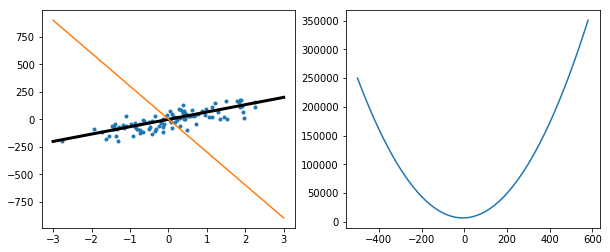

In [70]:
# Parameters for batch gradient descent
N_iterations = [2,5,10,20,40]
eta = 0.1
w_start = np.array([-400,0])

# (2.) - (4.) -> Variation of the number of iterations 
# (2.) - (4.) -> Variation of the number of iterations 
best_fit_x = np.linspace(round(min(X_train[:,0])),np.ceil(max(X_train[:,0])), 20)

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1.plot(X_train[:,0], y_train, '.')
ax2 = fig.add_subplot(122)
ax2.plot(w_range,J, '-')
analytic_y = [ols.coef_[1] + ols.coef_[0]*xx for xx in best_fit_x]
ax1.plot(best_fit_x, analytic_y, 'k-',label='analytic',lw=3)

for count, n_iter in enumerate(N_iterations):
    (w_opt, cost_history) = gradient_descent(X_train,y_train,eta,n_iter,w_start)
    
    best_fit_y = [w_opt[1] + w_opt[0]*xx for xx in best_fit_x]
    ax1.plot(best_fit_x, best_fit_y,
             label='GD: $N_{iter}$ = %i' % n_iter)
    ax2.plot(w_opt[0], cost_history[-1],'.',markersize=15)

In [60]:
len(cost_history)

40

### Q3.2.1: What can you observe from the two plots for an increased number of iterations $N_{iter}$?


### Q3.2.2: Assume you apply your best linear regression model $\hat{\mathbf{w}}$ to your *test* data and compare the test error to your training error. What do you expect and why? What is your expectation if you would do the same with the analytical solution of the OLS linear regression model?


### Variation of the learning rate

In [8]:
# Parameters for batch gradient descent
N_iterations = 5
eta = [1e-4, 1e-2, 0.02,1]
w_start = np.array([-400,0])

# (5.) -> Variation of the learning rate


### Q3.2.3: What happens if you choose a learning rate $\eta >> 1$ ?


## 3.2.3 Pitfalls of gradient descent

__Bonus:__ The use of iterative optimization methods (such as gradient descent) is not restricted to linear models, and for some problems an analytical solution may not even exist (or has not been found yet). For this reason, many complex Machine Learning models are trained using iterative optimization. 
However, iterative optimization of more complex problems comes at a price... Let's take a look at such situations by choosing a different model class (sine instead of linear functions)!

__Tasks:__ 
1. Visualize the given data set. Note that the second dimension of $\mathbf{X}$ contains ones to make use of the augmented notation.
2. Modify your MSE cost function of section 3.3.2 such that you can fit a model $f(\mathbf{x})=\sin(\mathbf{w}^T\mathbf{x})$.  
3. Set $w_{1}=1$ and evaluate the cost function $J(w_{0})$ for values $w_{0}\in[-4\pi,4\pi]$. Visualize your results.

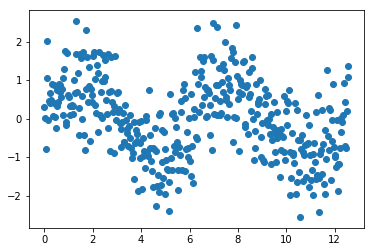

In [77]:
data_dir = 'data/GD_dataset2.data'
label_dir = 'data/GD_dataset2.labels'

X = np.loadtxt(data_dir)
y = np.loadtxt(label_dir)

# (1.) -> Visualize the given data set
X.shape, y.shape
fig, ax = plt.subplots(1,1)
ax.scatter(X[:, 0], y)

In [81]:
# (2.) -> Modified cost function
def cost_function(X, y, w):
    """cost_function(X, y, w) compute the MSE cost using w as the
    coefficients for linear regression to fit the data points in X and y
    
    Input:
    X: array with data matrix X
    y: observed output vector
    w: regression weights (compact form)

    Return: 
    J: scalar cost

    """
    ## number of training examples
    N_sam = X.shape[0]
     
    ## Calculate the MSE cost with the given parameters
    prediction = np.matmul(X, w)
    error = np.sin(prediction) - y.reshape(N_sam, 1)
    J = np.mean(np.power(error, 2), axis=0)
    
    return J

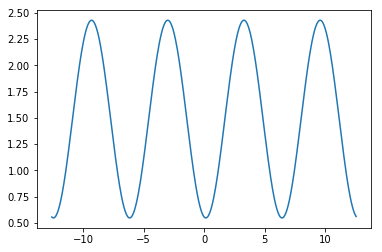

In [83]:
# (3.) -> Evaluate the cost function for different values of w_0
w_range = np.arange(-4*np.pi, 4*np.pi, .05)
cost = [0]*w_range.shape[0]
for i, w in enumerate(w_range):
    weight = np.array([1, w]).reshape(2,1)
    cost[i] = cost_function(X, y, weight)
fig, ax = plt.subplots(1,1)
ax.plot(w_range, cost)
ax.set_xla 


### Q3.2.4: What happens if you now apply the iterative gradient descent approach?


